Unique labels: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


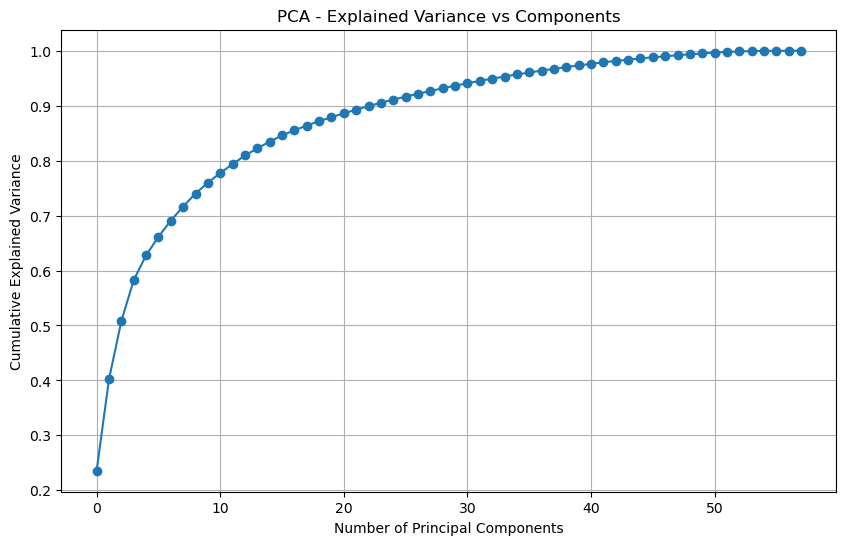

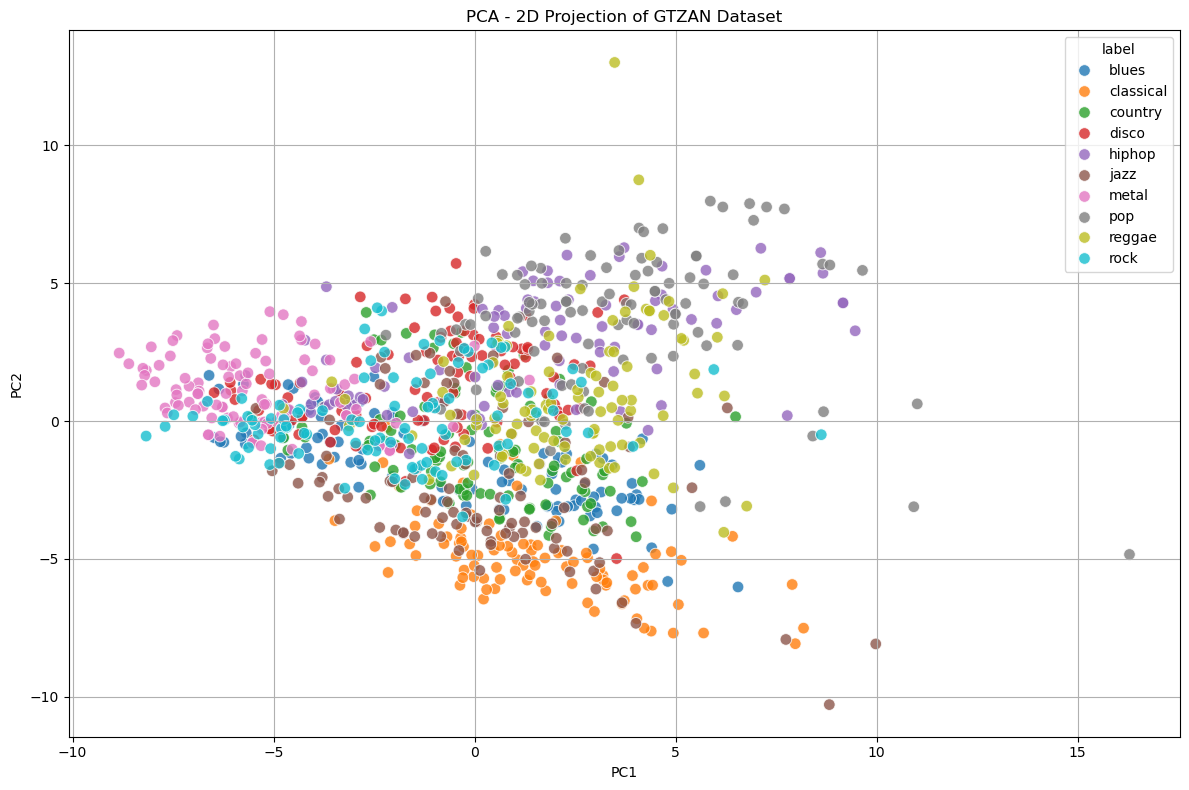

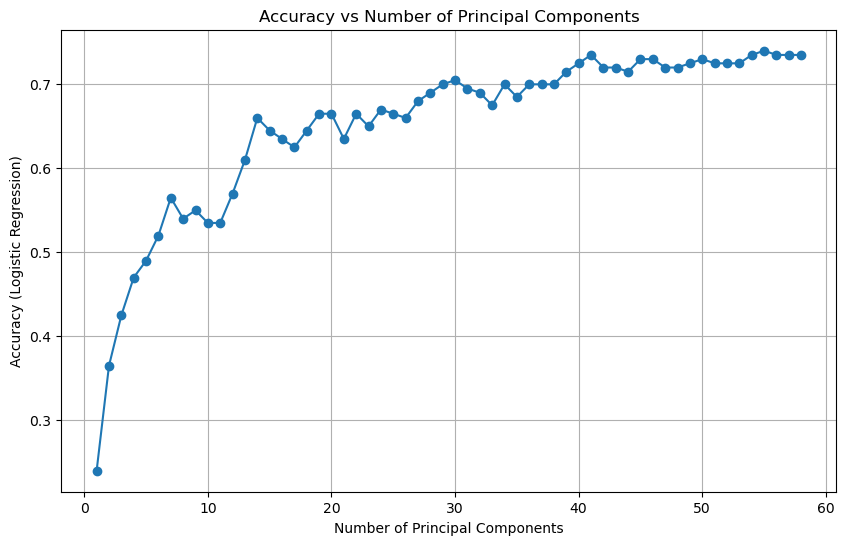

Best number of principal components to use: 55
Best logistic regression accuracy: 0.7400
Random Forest Accuracy with 55 PCs: 0.6650


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns

# Step 1: Load your dataset
data = pd.read_csv('../gtzan/features_30_sec.csv')

# Step 2: Separate features and labels
if 'filename' in data.columns:
    data['label'] = data['filename'].str.extract(r'^([a-zA-Z]+)')
    features = data.drop(columns=['filename', 'label'])
    labels = data['label']
    print("Unique labels:", labels.unique())
else:
    features = data
    labels = None

# Step 3: Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 4: Apply PCA (full PCA)
pca = PCA()
principal_components = pca.fit_transform(scaled_features)

# Step 5: Plot cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10,6))
plt.plot(np.cumsum(explained_variance_ratio), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance vs Components')
plt.grid()
plt.show()

# Step 6: PCA 2D visualization (only PC1 and PC2)
pca_2d = PCA(n_components=2)
principal_components_2d = pca_2d.fit_transform(scaled_features)

pca_df = pd.DataFrame(data=principal_components_2d, columns=['PC1', 'PC2'])

if labels is not None:
    pca_df['label'] = labels

plt.figure(figsize=(12,8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='label', palette='tab10', s=70, alpha=0.8)
plt.title('PCA - 2D Projection of GTZAN Dataset')
plt.grid()
plt.tight_layout()
plt.show()

# Step 7: Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Step 8: Train/test split on full principal components
X_train, X_test, y_train, y_test = train_test_split(
    principal_components, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

# Step 9: Train Logistic Regression using first k PCs
max_pcs = principal_components.shape[1]
accuracies = []

for k in range(1, max_pcs + 1):
    X_train_k = X_train[:, :k]
    X_test_k = X_test[:, :k]
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_k, y_train)
    
    y_pred = model.predict(X_test_k)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Step 10: Plot accuracy vs number of principal components
plt.figure(figsize=(10,6))
plt.plot(range(1, max_pcs+1), accuracies, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy (Logistic Regression)')
plt.title('Accuracy vs Number of Principal Components')
plt.grid()
plt.show()

# Step 11: Find the best number of components
best_k = np.argmax(accuracies) + 1  # +1 because Python is 0-indexed
print(f"Best number of principal components to use: {best_k}")
print(f"Best logistic regression accuracy: {accuracies[best_k-1]:.4f}")

# Step 12: Train a Non-Linear Model (Random Forest) with best_k PCs
X_train_best = X_train[:, :best_k]
X_test_best = X_test[:, :best_k]

non_linear_model = RandomForestClassifier(n_estimators=100, random_state=42)
non_linear_model.fit(X_train_best, y_train)

y_pred_rf = non_linear_model.predict(X_test_best)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest Accuracy with {best_k} PCs: {rf_accuracy:.4f}")
